In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import skimage.transform
import numpy as np
import keras
from tqdm import tqdm

from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.backend.tensorflow_backend import set_session
from sklearn.model_selection import train_test_split

config = tf.ConfigProto()
config.gpu_options.allow_growth=True
set_session(tf.Session(config=config))

/home/xnguyen/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from random import shuffle
ZERO_IMG_FRACTION = 0.5 #retain only a fraction of images with 0 steering angles 

#data generator
def data_gen(files, steering_angles, batch_size=32, data_dir='./data', flip=True):
    """
    Generator to yield inputs and steering angles.
    """        
    data = list(zip(files, steering_angles))

    img_id = 0    
    cnt = 0
    shuffle(data)        
    img_array = []
    y_arr = []
    
    while True:        
        if np.abs(data[img_id][1])>0 or (data[img_id][1]==0  and np.random.rand()<ZERO_IMG_FRACTION):
            # load data from file
            img_path = './data/IMG/%s'%data[img_id][0].split('/')[-1]
            img = image.load_img(img_path, target_size=(160, 320))
            
            # data preprocessing
            x = image.img_to_array(img)
            x = (x-128)/128.                
            y = data[img_id][1]

            #data augmentation
            if flip and np.random.rand()>0.5:
                x = np.fliplr(x)
                y = -y                                                                                                                                                                           

            img_array.append(x)
            y_arr.append(y)
            cnt += 1
            
        img_id += 1                    
        if img_id == len(data): 
            img_id = 0
            shuffle(data)
        
        if cnt == batch_size:
            cnt = 0
            yield np.asarray(img_array), y_arr
            img_array = []
            y_arr = []

In [3]:
#read and augment data. Keep only a fraction of images with zero steering angle
import pandas as pd
data_csv = pd.read_csv('./data/driving_log.csv',
                      names=['center','left','right','steering_angle','throttle','break','speed'])
files = data_csv['center'].tolist()
y = data_csv['steering_angle'].tolist()

In [4]:
# Randomly split data into train/valid set
X_train, X_test, y_train, y_test = train_test_split(files, y, test_size=0.05, random_state=42)

print("Training set: %d"%len(X_train))
print("Validation set: %d"%len(X_test))

Training set: 36132
Validation set: 1902


In [5]:
# Create train and validation set data generators
BATCH_SIZE = 512

train_generator      = data_gen(X_train, y_train, batch_size=BATCH_SIZE, data_dir='./data', flip=True)
validation_generator = data_gen(X_test, y_test, batch_size=BATCH_SIZE, data_dir='./data', flip=True)

In [10]:
#Defining drive-net model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import Cropping2D
from keras.models import Sequential, Model
from keras.layers import Lambda, Input
from keras import backend as K
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras import regularizers
from keras.models import load_model
import keras

L2_REG = 1e-6

model = Sequential()
model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160,320,3)))

model.add(Convolution2D(16, kernel_size=(3,3), 
                        activation = 'relu', 
                        input_shape=(160, 320, 3), 
                        init='he_normal', 
                        padding='same',
                        strides=(1, 1),
                        kernel_regularizer=regularizers.l2(L2_REG)))
model.add(Convolution2D(32, kernel_size=(3,3), 
                        activation = 'relu', 
                        input_shape=(160, 320, 3), 
                        init='he_normal', 
                        padding='same',
                        strides=(1, 1),
                        kernel_regularizer=regularizers.l2(L2_REG)))

model.add(MaxPooling2D(strides=(2, 2)))

model.add(Convolution2D(32,  kernel_size=(3,3),
                        activation = 'relu', 
                        init='he_normal', 
                        padding='same',
                        strides=(1, 1),
                        kernel_regularizer=regularizers.l2(L2_REG)))
model.add(Convolution2D(64,  kernel_size=(3,3),
                        activation = 'relu', 
                        init='he_normal', 
                        padding='same',
                        strides=(1, 1),
                        kernel_regularizer=regularizers.l2(L2_REG)))
model.add(MaxPooling2D(strides=(2, 2)))

model.add(Convolution2D(64,  kernel_size=(3,3),
                        activation = 'relu', 
                        init='he_normal', 
                        padding='same',
                        strides=(1, 1),
                        kernel_regularizer=regularizers.l2(L2_REG)))
model.add(Convolution2D(128,  kernel_size=(3,3),
                        activation = 'relu', 
                        init='he_normal', 
                        padding='same',
                        strides=(1, 1), 
                        kernel_regularizer=regularizers.l2(L2_REG)))
model.add(MaxPooling2D(strides=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation = 'relu', init='he_normal', kernel_regularizer=regularizers.l2(L2_REG)))
model.add(Dropout(0.5))
model.add(Dense(128, activation = 'relu', init='he_normal', kernel_regularizer=regularizers.l2(L2_REG)))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'linear', init='he_normal'))

/home/xnguyen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, input_shape=(160, 320,..., kernel_size=(3, 3), strides=(1, 1), kernel_initializer="he_normal", activation="relu", padding="same", kernel_regularizer=<keras.reg...)`
/home/xnguyen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, input_shape=(160, 320,..., kernel_size=(3, 3), strides=(1, 1), kernel_initializer="he_normal", activation="relu", padding="same", kernel_regularizer=<keras.reg...)`
/home/xnguyen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:41: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, kernel_size=(3, 3), strides=(1, 1), kernel_initializer="he_normal", activation="relu", padding="same", kernel_regularizer=<keras.reg...)`
/home/xnguyen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: UserWarning: Update

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_2 (Cropping2D)    (None, 90, 320, 3)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 90, 320, 16)       448       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 90, 320, 32)       4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 160, 32)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 45, 160, 32)       9248      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 45, 160, 64)       18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 22, 80, 64)        0         
__________

In [12]:
# Load a pretrained model, if training from a previous model
#model = load_model('model_1.h5')

Epoch 1/100
71/70 [==============================] - 110s 2s/step - loss: 0.0621 - val_loss: 0.0358
Epoch 2/100
71/70 [==============================] - 103s 1s/step - loss: 0.0416 - val_loss: 0.0343
Epoch 3/100
71/70 [==============================] - 102s 1s/step - loss: 0.0402 - val_loss: 0.0347
Epoch 4/100
71/70 [==============================] - 102s 1s/step - loss: 0.0392 - val_loss: 0.0318
Epoch 5/100
71/70 [==============================] - 101s 1s/step - loss: 0.0382 - val_loss: 0.0319
Epoch 6/100
71/70 [==============================] - 105s 1s/step - loss: 0.0378 - val_loss: 0.0311
Epoch 7/100
71/70 [==============================] - 106s 1s/step - loss: 0.0374 - val_loss: 0.0333
Epoch 8/100
71/70 [==============================] - 107s 2s/step - loss: 0.0371 - val_loss: 0.0310
Epoch 9/100
71/70 [==============================] - 107s 2s/step - loss: 0.0365 - val_loss: 0.0304
Epoch 10/100
71/70 [==============================] - 109s 2s/step - loss: 0.0366 - val_loss: 0.0296

71/70 [==============================] - 104s 1s/step - loss: 0.0314 - val_loss: 0.0272
Epoch 83/100
71/70 [==============================] - 103s 1s/step - loss: 0.0311 - val_loss: 0.0285
Epoch 84/100
71/70 [==============================] - 103s 1s/step - loss: 0.0312 - val_loss: 0.0283
Epoch 85/100
71/70 [==============================] - 103s 1s/step - loss: 0.0313 - val_loss: 0.0281
Epoch 86/100
71/70 [==============================] - 103s 1s/step - loss: 0.0310 - val_loss: 0.0271
Epoch 87/100
71/70 [==============================] - 104s 1s/step - loss: 0.0312 - val_loss: 0.0269
Epoch 88/100
71/70 [==============================] - 105s 1s/step - loss: 0.0312 - val_loss: 0.0278
Epoch 89/100
71/70 [==============================] - 104s 1s/step - loss: 0.0306 - val_loss: 0.0264
Epoch 90/100
71/70 [==============================] - 103s 1s/step - loss: 0.0311 - val_loss: 0.0275
Epoch 91/100
71/70 [==============================] - 105s 1s/step - loss: 0.0310 - val_loss: 0.0268
Epo

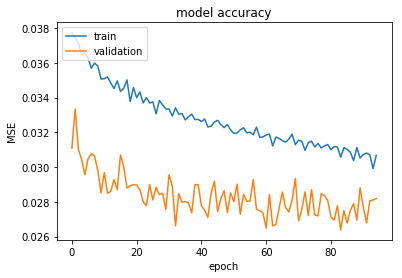

In [13]:
# Training drive-net with SGD with momentum
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9, decay=0, nesterov=True)

model.compile(optimizer=optimizer, loss='mean_squared_error')
history = model.fit_generator(train_generator,
                              steps_per_epoch=len(X_train) /
                              BATCH_SIZE, epochs=100,
                              validation_data=validation_generator, 
                              validation_steps=4)                    
print(history.history.keys())
plt.plot(history.history['loss'][5:])
plt.plot(history.history['val_loss'][5:])
plt.title('model accuracy')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [14]:
model.save('model_100.h5')

Epoch 1/100
71/70 [==============================] - 113s 2s/step - loss: 0.0304 - val_loss: 0.0273
Epoch 2/100
71/70 [==============================] - 108s 2s/step - loss: 0.0302 - val_loss: 0.0273
Epoch 3/100
71/70 [==============================] - 102s 1s/step - loss: 0.0304 - val_loss: 0.0275
Epoch 4/100
71/70 [==============================] - 108s 2s/step - loss: 0.0304 - val_loss: 0.0280
Epoch 5/100
71/70 [==============================] - 104s 1s/step - loss: 0.0303 - val_loss: 0.0271
Epoch 6/100
71/70 [==============================] - 103s 1s/step - loss: 0.0304 - val_loss: 0.0272
Epoch 7/100
71/70 [==============================] - 105s 1s/step - loss: 0.0304 - val_loss: 0.0275
Epoch 8/100
71/70 [==============================] - 104s 1s/step - loss: 0.0302 - val_loss: 0.0261
Epoch 9/100
71/70 [==============================] - 105s 1s/step - loss: 0.0304 - val_loss: 0.0272
Epoch 10/100
71/70 [==============================] - 100s 1s/step - loss: 0.0304 - val_loss: 0.0275

71/70 [==============================] - 106s 1s/step - loss: 0.0299 - val_loss: 0.0278
Epoch 83/100
71/70 [==============================] - 106s 1s/step - loss: 0.0301 - val_loss: 0.0270
Epoch 84/100
71/70 [==============================] - 107s 2s/step - loss: 0.0300 - val_loss: 0.0273
Epoch 85/100
71/70 [==============================] - 105s 1s/step - loss: 0.0301 - val_loss: 0.0278
Epoch 86/100
71/70 [==============================] - 107s 2s/step - loss: 0.0302 - val_loss: 0.0284
Epoch 87/100
71/70 [==============================] - 106s 1s/step - loss: 0.0301 - val_loss: 0.0278
Epoch 88/100
71/70 [==============================] - 105s 1s/step - loss: 0.0299 - val_loss: 0.0275
Epoch 89/100
71/70 [==============================] - 106s 1s/step - loss: 0.0301 - val_loss: 0.0277
Epoch 90/100
71/70 [==============================] - 105s 1s/step - loss: 0.0300 - val_loss: 0.0272
Epoch 91/100
71/70 [==============================] - 106s 1s/step - loss: 0.0296 - val_loss: 0.0278
Epo

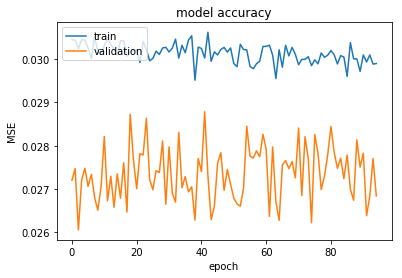

In [15]:
# Fine-tuning drive-net with SGD with momentum and a smaller learning rate
optimizer = keras.optimizers.SGD(lr=0.0001, momentum=0.9, decay=0, nesterov=True)

model.compile(optimizer=optimizer, loss='mean_squared_error')
history = model.fit_generator(train_generator,
                              steps_per_epoch=len(X_train) /
                              BATCH_SIZE, epochs=100,
                              validation_data=validation_generator, 
                              validation_steps=4)                    
print(history.history.keys())
plt.plot(history.history['loss'][5:])
plt.plot(history.history['val_loss'][5:])
plt.title('model accuracy')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [16]:
model.save('model_200.h5')